# ClusterCAD PKS Structural Data Exploration

This notebook provides an overview and summary of the predicted structural data for Polyketide Synthase (PKS) proteins from the ClusterCAD database.

## Dataset Overview

The data consists of **5 CSV files** containing different aspects of PKS structural predictions:

| File | Rows | Columns | Description |
|------|------|---------|-------------|
| `domain_macroproperties.csv` | 65,012 | 13 | Structural properties of individual PKS domains |
| `MP_PKS.csv` | 8,004 | 12 | Macroproperties for complete PKS module assemblies |
| `IA_out.csv` | 7,734 | 3 | Interface analysis with residue-level domain contacts |
| `IDO_out.csv` | 7,734 | 1,029 | Inter-domain organization (spatial relationships) |
| `MP_IA_IDO_combined.csv` | 8,006 | 1,043 | Combined macroproperties + spatial data |


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from collections import Counter
from scipy.spatial.transform import Rotation
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# =============================================================================
# DOMAIN FILTERING OPTIONS
# =============================================================================
# Set this to filter domain analyses:
#   'all'       - Include all domains
#   'catalytic' - Only catalytic domains (no linkers)
#   'linker'    - Only linker domains (names ending in 'L')
DOMAIN_FILTER = 'all'  # Options: 'all', 'catalytic', 'linker'

def is_linker_domain(domain_type):
    """Check if domain is a linker (ends with 'L' but not single letter domains)"""
    if len(domain_type) <= 2:
        return False
    return domain_type.endswith('L')

def filter_domains(df, domain_col='domain_type', filter_type=None):
    """Filter dataframe based on domain type"""
    if filter_type is None:
        filter_type = DOMAIN_FILTER
    
    if filter_type == 'all':
        return df
    elif filter_type == 'catalytic':
        return df[~df[domain_col].apply(is_linker_domain)]
    elif filter_type == 'linker':
        return df[df[domain_col].apply(is_linker_domain)]
    else:
        return df

print(f"Domain filter mode: {DOMAIN_FILTER}")
print("To change, modify DOMAIN_FILTER variable above and re-run cells")


---
## 1. Domain Macroproperties (`domain_macroproperties.csv`)

Contains **structural/geometric properties** for individual PKS domains extracted from predicted structures.

### Key Columns:
- **filename**: Source structure file (contains BGC ID, protein name, module, model number, domain type)
- **msms_density**: Molecular surface density
- **n_ca_atoms**: Number of Cα atoms (protein backbone) — indicates domain size
- **n_heavy_atoms**: Total non-hydrogen atoms
- **probe_radius**: Probe radius for surface calculations (Å)
- **radius_of_gyration_ca**: Compactness measure (Å) — lower = more compact
- **sasa**: Solvent Accessible Surface Area (Å²)
- **ses_area**: Solvent Excluded Surface Area (Å²)
- **vdw_volume**: Van der Waals volume (Å³)
- **vox_size**: Voxel size for calculations
- **zernike_order**: Order of Zernike shape descriptors


In [2]:
# Load domain macroproperties
domain_mp = pd.read_csv('domain_macroproperties.csv', index_col=0)

print(f"Shape: {domain_mp.shape}")
print(f"\nColumn names:")
for col in domain_mp.columns:
    print(f"  - {col}")


Shape: (65011, 12)

Column names:
  - filename
  - msms_density
  - n_ca_atoms
  - n_heavy_atoms
  - probe_radius
  - radius_of_gyration_ca
  - sasa
  - ses_area
  - vdw_volume
  - vox_size
  - zernike
  - zernike_order


In [3]:
domain_mp.head(10)


,filename,msms_density,n_ca_atoms,n_heavy_atoms,probe_radius,radius_of_gyration_ca,sasa,ses_area,vdw_volume,vox_size,zernike,zernike_order
0,domain_MP_fold_BGC0000001p1_abyB1_SingleModule_M0_Core_model_0_ACP_0860-0930.npz,1.0,142,1056,1.4,34.080021,4325.4870,3575.1358,11693.000,0.5,NaN,8
1,domain_MP_fold_BGC0000001p1_abyB1_SingleModule_M0_Core_model_0_ATACPL_0785-0859.npz,1.0,150,1164,1.4,44.729580,8425.8779,5838.6016,12867.375,0.5,NaN,8
2,domain_MP_fold_BGC0000001p1_abyB1_SingleModule_M0_Core_model_0_AT_0504-0784.npz,1.0,562,4212,1.4,67.743538,12722.2755,11340.4508,46913.375,0.5,NaN,8
3,domain_MP_fold_BGC0000001p1_abyB1_SingleModule_M0_Core_model_0_KSATL_0409-0503.npz,1.0,190,1336,1.4,43.405972,6779.6430,5165.6534,14870.625,0.5,NaN,8
4,domain_MP_fold_BGC0000001p1_abyB1_SingleModule_M0_Core_model_0_KS_0001-0408.npz,1.0,816,5990,1.4,25.078939,26881.6061,26418.1321,66431.750,0.5,NaN,8
5,domain_MP_fold_BGC0000001p1_abyB1_SingleModule_M0_Core_model_1_ACP_0860-0930.npz,1.0,142,1056,1.4,34.045769,4298.6740,3494.6229,11722.750,0.5,NaN,8
6,domain_MP_fold_BGC0000001p1_abyB1_SingleModule_M0_Core_model_1_ATACPL_0785-0859.npz,1.0,150,1164,1.4,44.675404,8259.0339,5745.9775,12846.750,0.5,NaN,8
7,domain_MP_fold_BGC0000001p1_abyB1_SingleModule_M0_Core_model_1_AT_0504-0784.npz,1.0,562,4212,1.4,67.383957,12472.1458,11185.2577,46818.750,0.5,NaN,8
8,domain_MP_fold_BGC0000001p1_abyB1_SingleModule_M0_Core_model_1_KSATL_0409-0503.npz,1.0,190,1336,1.4,43.140316,6738.5074,5184.9747,14866.750,0.5,NaN,8
9,domain_MP_fold_BGC0000001p1_abyB1_SingleModule_M0_Core_model_1_KS_0001-0408.npz,1.0,816,5990,1.4,25.057661,27011.6505,26491.6586,66406.375,0.5,NaN,8


In [ ]:
# Extract domain type from filename
def extract_domain_type(filename):
    """Extract domain type from filename pattern like ..._ACP_0860-0930.npz"""
    match = re.search(r'_([A-Za-z]+)_\d+-\d+\.npz$', filename)
    return match.group(1) if match else 'Unknown'

domain_mp['domain_type'] = domain_mp['filename'].apply(extract_domain_type)
domain_mp['is_linker'] = domain_mp['domain_type'].apply(is_linker_domain)

# Apply filter based on global setting
domain_mp_filtered = filter_domains(domain_mp)

# Count domain types
domain_counts = domain_mp_filtered['domain_type'].value_counts()
print(f"Domain type distribution (filter: {DOMAIN_FILTER}):")
print(f"Total domains: {len(domain_mp_filtered)} / {len(domain_mp)}")
print()

# Separate counts for catalytic and linker
catalytic_domains = domain_mp[~domain_mp['is_linker']]['domain_type'].value_counts()
linker_domains = domain_mp[domain_mp['is_linker']]['domain_type'].value_counts()

print("CATALYTIC DOMAINS:")
print(catalytic_domains)
print(f"\nLINKER DOMAINS:")
print(linker_domains)


Domain type distribution:
domain_type
AT         7733
ACP        7732
KS         7723
KSATL      7722
KRACPL     6795
KR         6793
DH         4641
ATDHL      4591
DHKRL      3294
ATKRL      2213
ER         1171
ERKRL      1151
DHERL      1141
ATACPL      768
TE          399
ACPTEL      399
cMT         120
DHACPL      115
cMTKRL      105
DHcMTL       80
ACPRL        45
R            45
AToMTL       45
oMT          45
ATcMTL       40
oMTKRL       30
ATERL        25
ERACPL       20
oMTACPL      15
cMTACPL      10
cMTERL        5
Name: count, dtype: int64


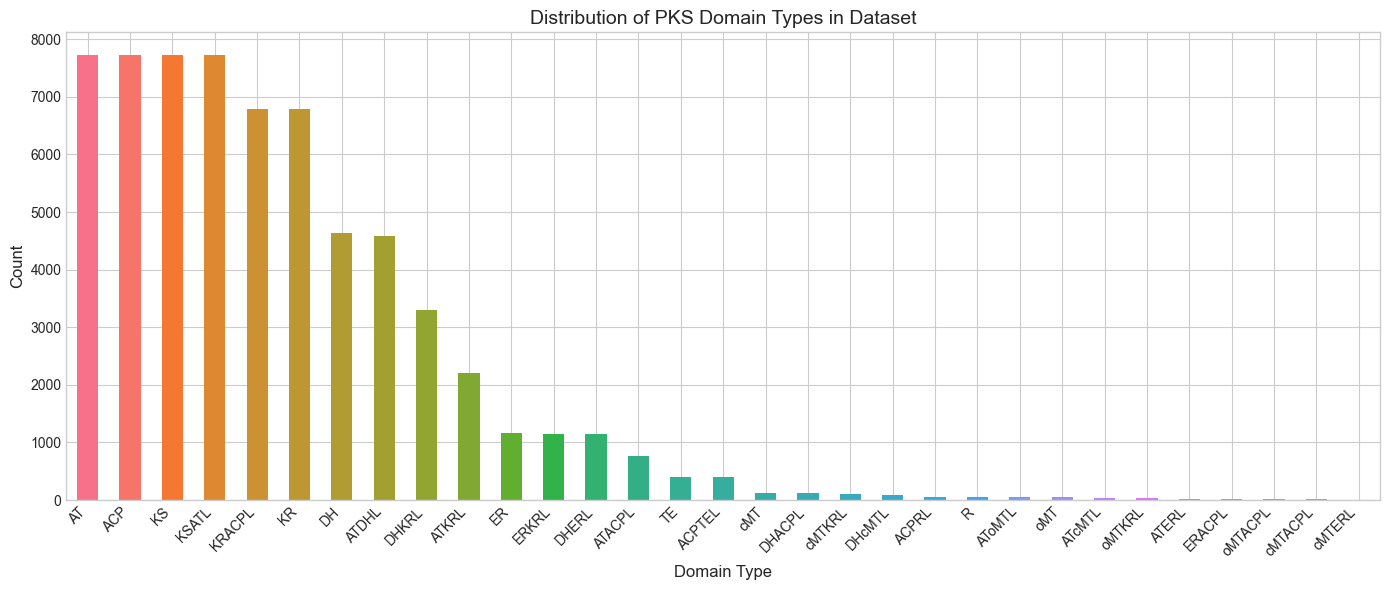

In [ ]:
# Plot domain type distribution with catalytic/linker distinction
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: All domains colored by type
ax = axes[0]
colors = ['#e74c3c' if is_linker_domain(d) else '#3498db' for d in domain_counts.index]
domain_counts.plot(kind='bar', ax=ax, color=colors)
ax.set_xlabel('Domain Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Distribution of PKS Domain Types (filter: {DOMAIN_FILTER})', fontsize=14)
plt.sca(ax)
plt.xticks(rotation=45, ha='right')
# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='Catalytic'),
                   Patch(facecolor='#e74c3c', label='Linker')]
ax.legend(handles=legend_elements, loc='upper right')

# Right plot: Pie chart of catalytic vs linker
ax = axes[1]
cat_count = len(domain_mp[~domain_mp['is_linker']])
link_count = len(domain_mp[domain_mp['is_linker']])
ax.pie([cat_count, link_count], labels=['Catalytic', 'Linker'], 
       autopct='%1.1f%%', colors=['#3498db', '#e74c3c'],
       explode=(0.02, 0.02), startangle=90)
ax.set_title('Catalytic vs Linker Domain Distribution', fontsize=14)

plt.tight_layout()
plt.show()


In [6]:
# Summary statistics for numeric columns
numeric_cols = ['msms_density', 'n_ca_atoms', 'n_heavy_atoms', 'radius_of_gyration_ca', 'sasa', 'ses_area', 'vdw_volume']
domain_mp[numeric_cols].describe()


,msms_density,n_ca_atoms,n_heavy_atoms,radius_of_gyration_ca,sasa,ses_area,vdw_volume
count,65011.0,65011.000000,65011.000000,65011.000000,65011.000000,65011.000000,65011.000000
mean,1.0,391.766101,2891.478550,42.624053,14593.032099,12436.660742,32089.086087
std,0.0,243.953094,1798.279071,12.845929,9419.462295,8622.779026,19931.974716
min,1.0,6.000000,50.000000,10.548997,585.290800,313.533900,533.250000
25%,1.0,182.000000,1340.000000,34.235773,8221.395300,6245.167800,14903.062500
50%,1.0,334.000000,2442.000000,42.229366,12479.461600,9814.285500,27074.125000
75%,1.0,594.000000,4416.000000,47.215576,19559.954200,16261.670850,49093.062500
max,1.0,1244.000000,9078.000000,86.966064,90501.116200,64039.836300,100365.375000


In [7]:
# Summary statistics by domain type
domain_summary = domain_mp.groupby('domain_type')[numeric_cols].agg(['mean', 'std']).round(2)
domain_summary


msms_density      n_ca_atoms         n_heavy_atoms           \
                    mean  std       mean     std          mean      std   
domain_type                                                               
ACP                  1.0  0.0     157.03   14.10       1189.30   109.51   
ACPRL                1.0  0.0      96.89   13.92        704.00   113.19   
ACPTEL               1.0  0.0     173.76  107.17       1280.03   854.72   
AT                   1.0  0.0     583.53   25.14       4350.25   207.17   
ATACPL               1.0  0.0     239.52  169.15       1811.46  1242.29   
ATDHL                1.0  0.0     138.46   23.39       1060.84   179.47   
ATERL                1.0  0.0     313.20  137.17       2389.60  1027.97   
ATKRL                1.0  0.0     646.92   77.66       4853.30   601.61   
ATcMTL               1.0  0.0     517.00   57.72       4108.25   542.97   
AToMTL               1.0  0.0     203.33   37.11       1606.22   301.46   
DH                   1.0  0.0     329.62   28.76       2436.88   237.88   
DHACPL               1.0  0.0     331.13  180.49       2414.96  1302.64   
DHERL                1.0  0.0     647.67   69.15       4762.04   523.77   
DHKRL                1.0  0.0     606.98   93.37       4443.86   691.66   
DHcMTL               1.0  0.0     519.38   73.07       4088.62   567.43   
ER                   1.0  0.0     607.21   18.26       4510.73   163.23   
ERACPL               1.0  0.0      58.00    0.00        427.50     0.89   
ERKRL                1.0  0.0      24.77   43.32        185.73   316.48   
KR                   1.0  0.0     354.71   12.68       2563.97   114.31   
KRACPL               1.0  0.0     194.60   20.71       1426.12   151.79   
KS                   1.0  0.0     845.91   20.01       6206.24   172.85   
KSATL                1.0  0.0     218.01   35.42       1571.18   242.32   
R                    1.0  0.0     481.11    1.93       3693.56    51.80   
TE                   1.0  0.0     420.39   25.14       3197.42   221.97   
cMT                  1.0  0.0     418.08   16.00       3284.00   133.06   
cMTACPL              1.0  0.0     464.00   18.97       3537.00   270.90   
cMTERL               1.0  0.0     470.00    0.00       3566.00     0.00   
cMTKRL               1.0  0.0     529.52  148.08       4083.71  1107.61   
oMT                  1.0  0.0     487.33   28.64       3892.89   244.99   
oMTACPL              1.0  0.0     126.00    0.00        988.00    11.71   
oMTKRL               1.0  0.0     572.33   18.77       4392.33    71.70   

            radius_of_gyration_ca             sasa            ses_area  \
                             mean    std      mean       std      mean   
domain_type                                                              
ACP                         40.14   6.38   4809.06    485.03   3893.71   
ACPRL                       62.75   7.78   5544.02    675.29   3706.38   
ACPTEL                      52.37  13.35  10058.77   5094.35   7117.06   
AT                          68.90   2.34  13085.84    805.32  11795.73   
ATACPL                      45.04   3.75  16324.03  12312.18  11726.19   
ATDHL                       41.91   2.02  14217.04   2730.26  10100.82   
ATERL                       50.76   5.25  19598.69  10885.19  14309.80   
ATKRL                       46.21   2.81  40642.92   7509.23  33035.03   
ATcMTL                      57.39   6.57  41370.86   8522.11  31846.88   
AToMTL                      45.30   3.05  16059.87   6658.79  11436.56   
DH                          27.71   3.41  19997.39   2209.25  16621.18   
DHACPL                      38.27   4.02  17800.73   9714.09  14245.31   
DHERL                       43.70   4.18  25271.19   9289.26  21179.31   
DHKRL                       44.66   3.56  20910.28   6909.22  17434.45   
DHcMTL                      53.11  10.20  24946.06   7984.42  19995.40   
ER                          38.96  11.85  19252.87   6389.23  17596.01   
ERACPL                      50.35   4.06   3783.58    1

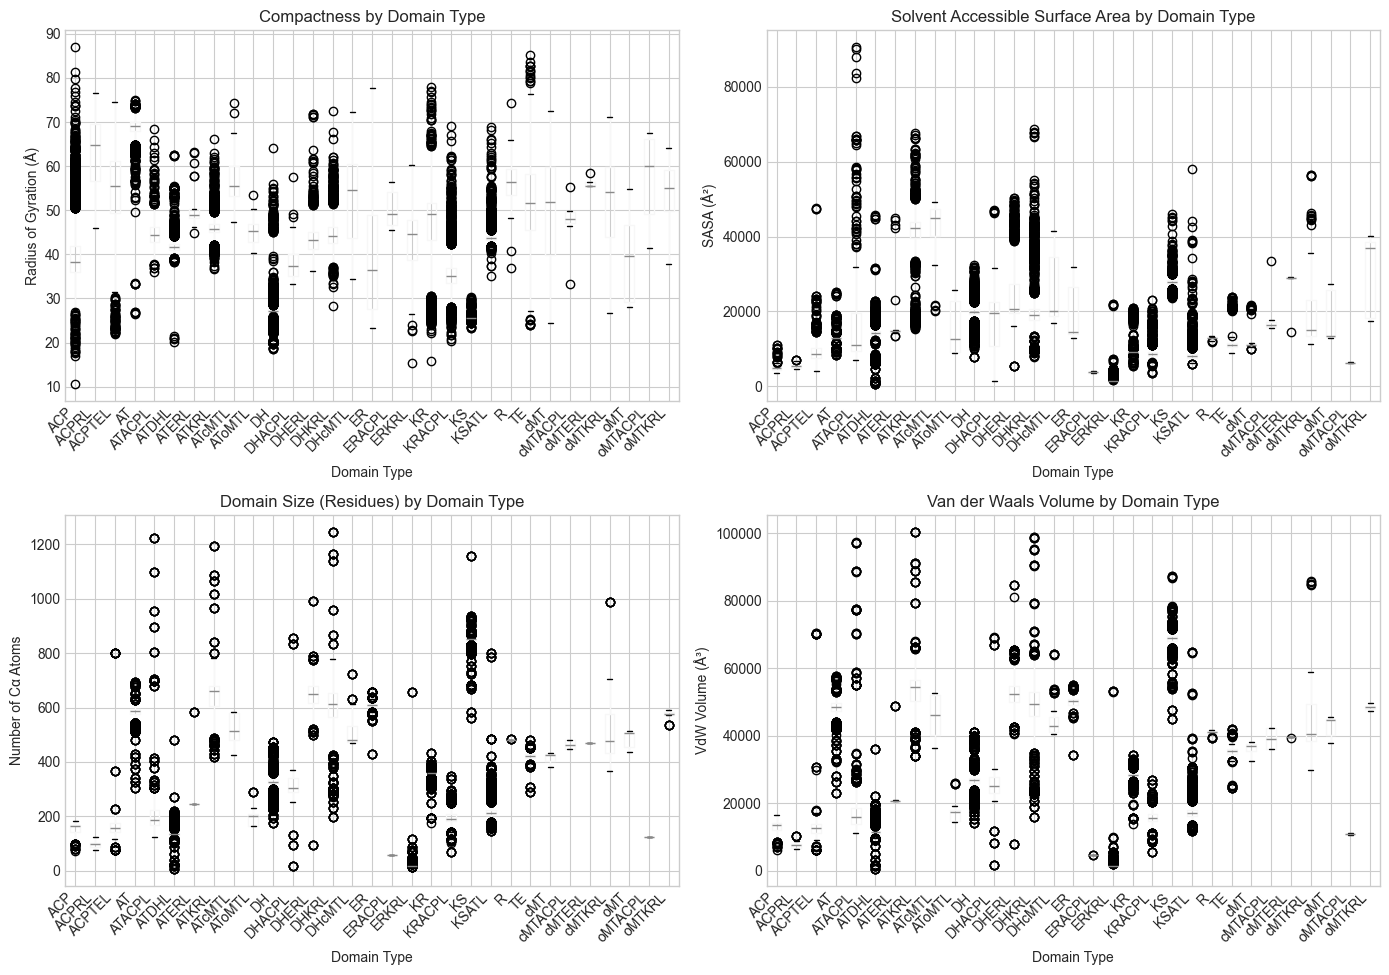

In [8]:
# Compare domain properties by type - visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Radius of gyration by domain type
ax = axes[0, 0]
domain_mp.boxplot(column='radius_of_gyration_ca', by='domain_type', ax=ax)
ax.set_xlabel('Domain Type')
ax.set_ylabel('Radius of Gyration (Å)')
ax.set_title('Compactness by Domain Type')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

# SASA by domain type
ax = axes[0, 1]
domain_mp.boxplot(column='sasa', by='domain_type', ax=ax)
ax.set_xlabel('Domain Type')
ax.set_ylabel('SASA (Å²)')
ax.set_title('Solvent Accessible Surface Area by Domain Type')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

# Number of Cα atoms by domain type
ax = axes[1, 0]
domain_mp.boxplot(column='n_ca_atoms', by='domain_type', ax=ax)
ax.set_xlabel('Domain Type')
ax.set_ylabel('Number of Cα Atoms')
ax.set_title('Domain Size (Residues) by Domain Type')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

# VdW Volume by domain type
ax = axes[1, 1]
domain_mp.boxplot(column='vdw_volume', by='domain_type', ax=ax)
ax.set_xlabel('Domain Type')
ax.set_ylabel('VdW Volume (Å³)')
ax.set_title('Van der Waals Volume by Domain Type')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

plt.suptitle('')  # Remove automatic title
plt.tight_layout()
plt.show()


---
## 2. Module Macroproperties (`MP_PKS.csv`)

Contains **structural properties for complete PKS module assemblies** (multiple domains together as they would function in the cell).

Same measurement types as domain_macroproperties, but aggregated at the module level.


In [9]:
# Load module macroproperties
module_mp = pd.read_csv('MP_PKS.csv')

print(f"Shape: {module_mp.shape}")
print(f"\nColumn names:")
for col in module_mp.columns:
    print(f"  - {col}")


Shape: (8003, 12)

Column names:
  - filename
  - msms_density
  - n_ca_atoms
  - n_heavy_atoms
  - probe_radius
  - radius_of_gyration_ca
  - sasa
  - ses_area
  - vdw_volume
  - vox_size
  - zernike
  - zernike_order


In [10]:
module_mp.head(10)


,filename,msms_density,n_ca_atoms,n_heavy_atoms,probe_radius,radius_of_gyration_ca,sasa,ses_area,vdw_volume,vox_size,zernike,zernike_order
0,MP_fold_bgc0000001p1_abyb1_singlemodule_m0_core_model_0.npz,1.0,1860,13758,1.4,46.943092,67958.6500,66232.5070,152659.125,0.5,NaN,8
1,MP_fold_bgc0000001p1_abyb1_singlemodule_m0_core_model_1.npz,1.0,1860,13758,1.4,46.759857,67753.7960,65757.1615,152527.500,0.5,NaN,8
2,MP_fold_bgc0000001p1_abyb1_singlemodule_m0_core_model_2.npz,1.0,1860,13758,1.4,46.864037,67814.8086,65913.9408,152519.500,0.5,NaN,8
3,MP_fold_bgc0000001p1_abyb1_singlemodule_m0_core_model_3.npz,1.0,1860,13758,1.4,46.802402,66977.1375,65060.1255,152491.875,0.5,NaN,8
4,MP_fold_bgc0000001p1_abyb1_singlemodule_m0_core_model_4.npz,1.0,1860,13758,1.4,46.827694,68405.2985,65838.9902,152701.875,0.5,NaN,8
5,MP_fold_bgc0000001p1_abyb1_singlemodule_m1_core_model_0.npz,1.0,3130,23466,1.4,50.463577,119956.3498,115787.9702,259760.500,0.5,NaN,8
6,MP_fold_bgc0000001p1_abyb1_singlemodule_m1_core_model_1.npz,1.0,3130,23466,1.4,50.943508,121198.8304,117713.5992,259756.000,0.5,NaN,8
7,MP_fold_bgc0000001p1_abyb1_singlemodule_m1_core_model_2.npz,1.0,3130,23466,1.4,50.168373,117415.6286,113527.9341,259719.625,0.5,NaN,8
8,MP_fold_bgc0000001p1_abyb1_singlemodule_m1_core_model_3.npz,1.0,3130,23466,1.4,50.618843,118034.9251,115770.9878,259817.750,0.5,NaN,8
9,MP_fold_bgc0000001p1_abyb1_singlemodule_m1_core_model_4.npz,1.0,3130,23466,1.4,50.278130,118357.4387,114370.0463,259801.875,0.5,NaN,8


In [11]:
# Extract module type (M0, M1, M2, etc.) from filename
def extract_module_info(filename):
    """Extract BGC, protein, and module info from filename"""
    # Pattern: MP_fold_bgc0000001p1_abyb1_singlemodule_m0_core_model_0.npz
    match = re.search(r'bgc(\d+)p(\d+)_(\w+)_\w+_(m\d+)_', filename.lower())
    if match:
        return {
            'bgc_num': match.group(1),
            'protein': match.group(3),
            'module': match.group(4).upper()
        }
    return {'bgc_num': None, 'protein': None, 'module': None}

# Apply extraction
module_info = module_mp['filename'].apply(extract_module_info).apply(pd.Series)
module_mp = pd.concat([module_mp, module_info], axis=1)

print("Module distribution:")
print(module_mp['module'].value_counts().head(15))


Module distribution:
module
M1     850
M2     810
M3     775
M4     720
M5     705
M6     630
M0     570
M7     554
M8     460
M9     369
M10    320
M11    270
M12    210
M13    145
M14    110
Name: count, dtype: int64


In [12]:
# Module-level statistics
numeric_cols_module = ['n_ca_atoms', 'n_heavy_atoms', 'radius_of_gyration_ca', 'sasa', 'ses_area', 'vdw_volume']
module_mp[numeric_cols_module].describe()


,n_ca_atoms,n_heavy_atoms,radius_of_gyration_ca,sasa,ses_area,vdw_volume
count,8003.000000,8003.000000,8003.000000,8003.000000,8003.000000,8003.000000
mean,3295.940272,24325.491441,51.591408,127520.681707,123862.101995,269553.560369
std,582.103821,4335.543828,2.387348,22653.288239,22875.174117,47982.669059
min,1030.000000,7550.000000,38.571510,57734.279800,49016.573500,83783.375000
25%,3012.000000,22152.000000,50.212099,114732.645200,111240.215050,245356.687500
50%,3376.000000,24696.000000,51.224632,128546.760900,125423.886500,273653.125000
75%,3560.000000,26348.000000,52.633152,140285.483100,135822.562000,291877.875000
max,4956.000000,38352.000000,66.331024,205255.588600,194914.355600,430287.151235


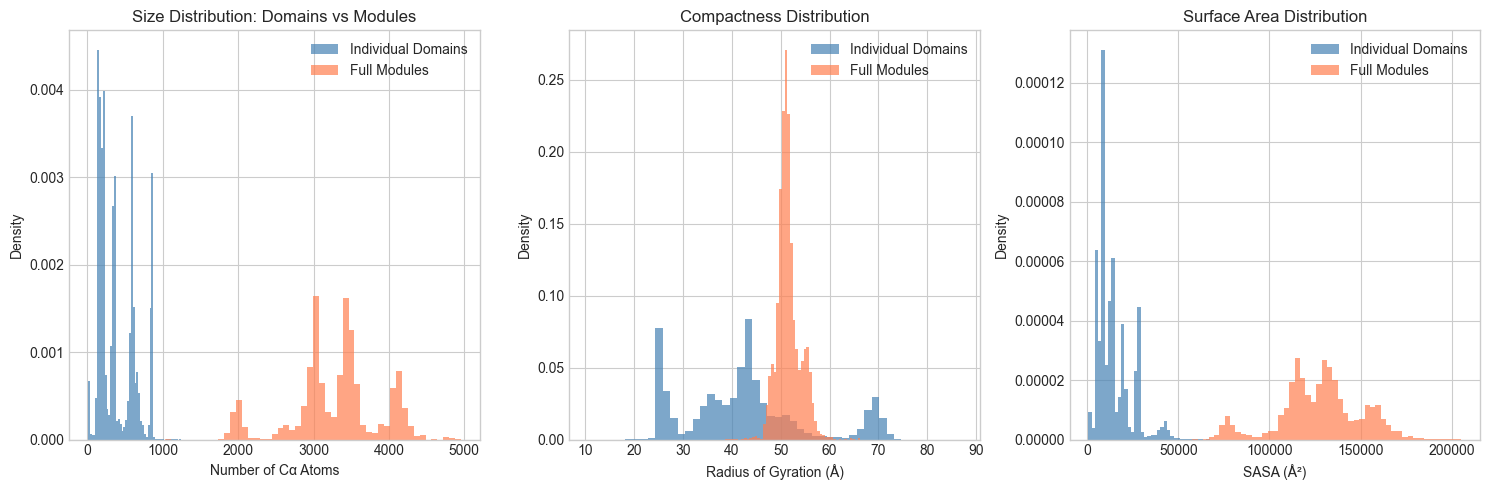

In [13]:
# Compare domain vs module sizes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Cα atoms comparison
ax = axes[0]
ax.hist(domain_mp['n_ca_atoms'], bins=50, alpha=0.7, label='Individual Domains', density=True, color='steelblue')
ax.hist(module_mp['n_ca_atoms'], bins=50, alpha=0.7, label='Full Modules', density=True, color='coral')
ax.set_xlabel('Number of Cα Atoms')
ax.set_ylabel('Density')
ax.set_title('Size Distribution: Domains vs Modules')
ax.legend()

# Radius of gyration
ax = axes[1]
ax.hist(domain_mp['radius_of_gyration_ca'], bins=50, alpha=0.7, label='Individual Domains', density=True, color='steelblue')
ax.hist(module_mp['radius_of_gyration_ca'], bins=50, alpha=0.7, label='Full Modules', density=True, color='coral')
ax.set_xlabel('Radius of Gyration (Å)')
ax.set_ylabel('Density')
ax.set_title('Compactness Distribution')
ax.legend()

# SASA
ax = axes[2]
ax.hist(domain_mp['sasa'], bins=50, alpha=0.7, label='Individual Domains', density=True, color='steelblue')
ax.hist(module_mp['sasa'], bins=50, alpha=0.7, label='Full Modules', density=True, color='coral')
ax.set_xlabel('SASA (Å²)')
ax.set_ylabel('Density')
ax.set_title('Surface Area Distribution')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# COMPREHENSIVE MODULE MACROPROPERTIES ANALYSIS
# ============================================================================

# Similar boxplots to domain analysis for modules
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Radius of gyration by module number
ax = axes[0, 0]
module_mp.boxplot(column='radius_of_gyration_ca', by='module', ax=ax)
ax.set_xlabel('Module Number')
ax.set_ylabel('Radius of Gyration (Å)')
ax.set_title('Module Compactness by Position')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

# 2. SASA by module number
ax = axes[0, 1]
module_mp.boxplot(column='sasa', by='module', ax=ax)
ax.set_xlabel('Module Number')
ax.set_ylabel('SASA (Å²)')
ax.set_title('Surface Area by Module Position')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

# 3. Number of Cα atoms by module
ax = axes[0, 2]
module_mp.boxplot(column='n_ca_atoms', by='module', ax=ax)
ax.set_xlabel('Module Number')
ax.set_ylabel('Number of Cα Atoms')
ax.set_title('Module Size by Position')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

# 4. VdW Volume by module
ax = axes[1, 0]
module_mp.boxplot(column='vdw_volume', by='module', ax=ax)
ax.set_xlabel('Module Number')
ax.set_ylabel('VdW Volume (Å³)')
ax.set_title('Volume by Module Position')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

# 5. SES Area by module
ax = axes[1, 1]
module_mp.boxplot(column='ses_area', by='module', ax=ax)
ax.set_xlabel('Module Number')
ax.set_ylabel('SES Area (Å²)')
ax.set_title('Solvent Excluded Surface by Module')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

# 6. Heavy atoms by module
ax = axes[1, 2]
module_mp.boxplot(column='n_heavy_atoms', by='module', ax=ax)
ax.set_xlabel('Module Number')
ax.set_ylabel('Number of Heavy Atoms')
ax.set_title('Heavy Atom Count by Module')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

plt.suptitle('Module Macroproperties by Position in PKS Assembly', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Correlation heatmap for module properties
fig, ax = plt.subplots(figsize=(10, 8))
corr_matrix = module_mp[numeric_cols_module].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax, fmt='.2f')
ax.set_title('Correlation Between Module Structural Properties', fontsize=14)
plt.tight_layout()
plt.show()

# Distribution plots for each property
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(numeric_cols_module):
    ax = axes.flat[i]
    ax.hist(module_mp[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='teal')
    ax.axvline(module_mp[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {module_mp[col].mean():.1f}')
    ax.axvline(module_mp[col].median(), color='orange', linestyle=':', linewidth=2, label=f'Median: {module_mp[col].median():.1f}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {col}')
    ax.legend(fontsize=8)
plt.suptitle('Module Property Distributions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Scatter plots showing relationships between key properties
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Size vs Surface Area
ax = axes[0]
ax.scatter(module_mp['n_ca_atoms'], module_mp['sasa'], alpha=0.5, c='teal', s=10)
ax.set_xlabel('Number of Cα Atoms')
ax.set_ylabel('SASA (Å²)')
ax.set_title('Module Size vs Surface Area')
# Add correlation
r = module_mp['n_ca_atoms'].corr(module_mp['sasa'])
ax.text(0.05, 0.95, f'r = {r:.3f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Size vs Compactness
ax = axes[1]
ax.scatter(module_mp['n_ca_atoms'], module_mp['radius_of_gyration_ca'], alpha=0.5, c='coral', s=10)
ax.set_xlabel('Number of Cα Atoms')
ax.set_ylabel('Radius of Gyration (Å)')
ax.set_title('Module Size vs Compactness')
r = module_mp['n_ca_atoms'].corr(module_mp['radius_of_gyration_ca'])
ax.text(0.05, 0.95, f'r = {r:.3f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Volume vs Surface Area
ax = axes[2]
ax.scatter(module_mp['vdw_volume'], module_mp['sasa'], alpha=0.5, c='purple', s=10)
ax.set_xlabel('VdW Volume (Å³)')
ax.set_ylabel('SASA (Å²)')
ax.set_title('Module Volume vs Surface Area')
r = module_mp['vdw_volume'].corr(module_mp['sasa'])
ax.text(0.05, 0.95, f'r = {r:.3f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.show()


---
## 3. Interface Analysis (`IA_out.csv`)

Contains **residue-level interface information** between domains. This data describes which residues are in contact at domain-domain interfaces.

### Columns:
- **filename**: Source structure file
- **domains**: JSON dictionary with domain boundaries (start/end residue numbers)
- **interfaces**: JSON with detailed residue contacts at each domain-domain interface

This data is essential for understanding:
- How domains interact
- Which residues are important for domain-domain communication
- Interface sizes and compositions


In [14]:
# Load interface analysis data
ia_df = pd.read_csv('IA_out.csv')

print(f"Shape: {ia_df.shape}")
print(f"\nColumn names: {list(ia_df.columns)}")


Shape: (7733, 3)

Column names: ['filename', 'domains', 'interfaces']


In [15]:
# Show an example row
print("Example domains structure:")
print(ia_df['domains'].iloc[0][:500])
print("\n...")
print("\nExample interfaces structure (truncated):")
print(ia_df['interfaces'].iloc[0][:800])
print("\n...")


Example domains structure:
{"ACP": [860, 930], "ATACPL": [785, 859], "AT": [504, 784], "KSATL": [409, 503], "KS": [1, 408]}

...

Example interfaces structure (truncated):
{"ACP-ATACPL": {"ACP": ["A860", "A861", "A862", "A863", "A865", "A868", "A869", "A871", "A872", "A873", "A874", "A875", "A876", "A901", "A905", "A906", "A907", "A925", "A928", "A929", "B860", "B861", "B862", "B863", "B865", "B868", "B869", "B871", "B872", "B873", "B874", "B875", "B876", "B901", "B905", "B906", "B907", "B925", "B928", "B929"], "ATACPL": ["A828", "A830", "A836", "A837", "A838", "A839", "A840", "A841", "A842", "A844", "A852", "A854", "A855", "A856", "A857", "A858", "A859", "B828", "B830", "B836", "B838", "B839", "B840", "B841", "B842", "B844", "B854", "B855", "B856", "B857", "B858", "B859"]}, "ACP-KS": {"ACP": ["A869", "A870", "A871", "A872", "A873", "A886", "A889", "A891", "A892", "A893", "A894", "A896", "A897", "A899", "A901", "A911", "A912", "A913", "A916", "A917", "B869",

...


In [16]:
# Parse domains column to extract domain types present
def extract_domains_from_json(domains_str):
    try:
        domains = json.loads(domains_str.replace("'", '"'))
        return list(domains.keys())
    except:
        return []

ia_df['domain_list'] = ia_df['domains'].apply(extract_domains_from_json)
ia_df['n_domains'] = ia_df['domain_list'].apply(len)

print("Number of domains per structure:")
print(ia_df['n_domains'].value_counts().sort_index())


Number of domains per structure:
n_domains
3        5
5      665
7     2377
8       36
9     3229
10       5
11    1386
13      30
Name: count, dtype: int64


In [17]:
# Count interface types
def extract_interfaces(interfaces_str):
    try:
        interfaces = json.loads(interfaces_str.replace("'", '"'))
        return list(interfaces.keys())
    except:
        return []

ia_df['interface_list'] = ia_df['interfaces'].apply(extract_interfaces)
ia_df['n_interfaces'] = ia_df['interface_list'].apply(len)

# Flatten all interfaces
all_interfaces = [iface for ifaces in ia_df['interface_list'] for iface in ifaces]
interface_counts = Counter(all_interfaces)

print("Top 25 interface types:")
for iface, count in interface_counts.most_common(25):
    print(f"  {iface}: {count}")


Top 25 interface types:
  AT-KSATL: 7723
  KS-KSATL: 7723
  KR-KRACPL: 6794
  ACP-KRACPL: 6793
  ACP-KS: 6379
  KRACPL-KS: 5655
  AT-ATDHL: 4591
  ATDHL-DH: 4591
  ATDHL-KSATL: 4581
  ATDHL-KS: 4546
  DH-KRACPL: 4451
  ACP-KSATL: 4214
  DH-KS: 4076
  DH-DHKRL: 3295
  DHKRL-KR: 3295
  DHKRL-KRACPL: 3295
  ACP-KR: 3029
  ACP-DHKRL: 3005
  ATDHL-DHKRL: 2994
  AT-ATKRL: 2213
  ATKRL-KR: 2213
  ATKRL-KRACPL: 2213
  ATKRL-KSATL: 2208
  ATKRL-KS: 2206
  KR-KS: 1931


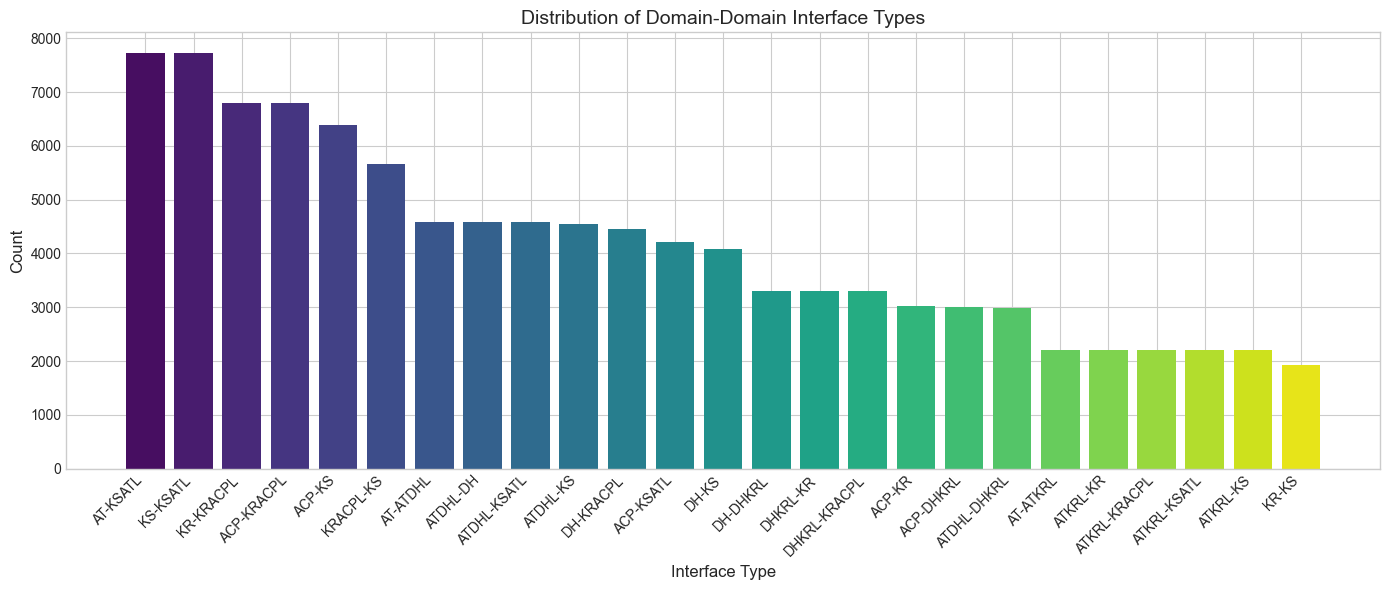

In [18]:
# Plot interface type distribution
fig, ax = plt.subplots(figsize=(14, 6))
interfaces_df = pd.DataFrame(interface_counts.most_common(25), columns=['Interface', 'Count'])
colors = sns.color_palette('viridis', len(interfaces_df))
bars = ax.bar(interfaces_df['Interface'], interfaces_df['Count'], color=colors)
ax.set_xlabel('Interface Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Domain-Domain Interface Types', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# ENHANCED INTERFACE ANALYSIS
# ============================================================================

def parse_interface_details(interfaces_str):
    """Parse interface JSON and extract detailed statistics"""
    try:
        interfaces = json.loads(interfaces_str.replace("'", '"'))
        details = {}
        for iface_name, iface_data in interfaces.items():
            total_residues = 0
            residue_counts = {}
            for domain_name, residues in iface_data.items():
                n_res = len(residues)
                residue_counts[domain_name] = n_res
                total_residues += n_res
            details[iface_name] = {
                'total_contacts': total_residues,
                'domain_contacts': residue_counts,
                'n_domains': len(iface_data)
            }
        return details
    except:
        return {}

# Parse all interfaces
ia_df['interface_details'] = ia_df['interfaces'].apply(parse_interface_details)

# Extract contact counts for each interface type
def get_contact_counts_by_interface(row):
    """Get contact count for each interface"""
    result = {}
    for iface, details in row['interface_details'].items():
        result[iface] = details['total_contacts']
    return result

ia_df['contact_counts'] = ia_df['interface_details'].apply(
    lambda x: {k: v['total_contacts'] for k, v in x.items()}
)

print("Sample interface details:")
sample = ia_df.iloc[0]['interface_details']
for iface, details in list(sample.items())[:3]:
    print(f"\n{iface}:")
    print(f"  Total contacts: {details['total_contacts']}")
    print(f"  Per domain: {details['domain_contacts']}")


In [ ]:
# Analyze interface sizes (number of contacts) for each interface type
interface_contact_stats = {}

for idx, row in ia_df.iterrows():
    for iface_name, contact_count in row['contact_counts'].items():
        if iface_name not in interface_contact_stats:
            interface_contact_stats[iface_name] = []
        interface_contact_stats[iface_name].append(contact_count)

# Create summary statistics
interface_stats_df = pd.DataFrame({
    'Interface': list(interface_contact_stats.keys()),
    'Count': [len(v) for v in interface_contact_stats.values()],
    'Mean_Contacts': [np.mean(v) for v in interface_contact_stats.values()],
    'Std_Contacts': [np.std(v) for v in interface_contact_stats.values()],
    'Min_Contacts': [np.min(v) for v in interface_contact_stats.values()],
    'Max_Contacts': [np.max(v) for v in interface_contact_stats.values()],
})

interface_stats_df = interface_stats_df.sort_values('Count', ascending=False)
print("Interface Statistics (by number of contacts):")
display(interface_stats_df.head(20))


In [ ]:
# Visualize interface contact distributions for top interfaces
top_interfaces = interface_stats_df.head(12)['Interface'].tolist()

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for i, iface in enumerate(top_interfaces):
    ax = axes[i]
    contacts = interface_contact_stats[iface]
    ax.hist(contacts, bins=30, edgecolor='black', alpha=0.7, color=plt.cm.viridis(i/len(top_interfaces)))
    ax.axvline(np.mean(contacts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(contacts):.1f}')
    ax.set_xlabel('Number of Contacts')
    ax.set_ylabel('Count')
    ax.set_title(f'{iface}\n(n={len(contacts)})', fontsize=10)
    ax.legend(fontsize=8)

plt.suptitle('Distribution of Contact Counts by Interface Type', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Boxplot comparison of interface sizes
fig, ax = plt.subplots(figsize=(16, 8))

# Prepare data for boxplot
plot_data = []
plot_labels = []
for iface in interface_stats_df.head(20)['Interface'].tolist():
    plot_data.append(interface_contact_stats[iface])
    plot_labels.append(iface)

bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True)

# Color boxes
colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_xlabel('Interface Type', fontsize=12)
ax.set_ylabel('Number of Contacts', fontsize=12)
ax.set_title('Interface Size Distribution (Top 20 by Frequency)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary: largest and smallest interfaces on average
print("\nLargest interfaces (by mean contacts):")
print(interface_stats_df.nlargest(10, 'Mean_Contacts')[['Interface', 'Mean_Contacts', 'Count']])

print("\nSmallest interfaces (by mean contacts):")
print(interface_stats_df.nsmallest(10, 'Mean_Contacts')[['Interface', 'Mean_Contacts', 'Count']])


In [ ]:
# Analyze which domains participate in the most interfaces
domain_interface_participation = Counter()

for idx, row in ia_df.iterrows():
    for iface in row['interface_list']:
        # Parse domain names from interface (e.g., "ACP-KS" -> ["ACP", "KS"])
        domains = iface.split('-')
        for domain in domains:
            domain_interface_participation[domain] += 1

# Plot domain interface participation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All domains
ax = axes[0]
domain_df = pd.DataFrame(domain_interface_participation.most_common(), columns=['Domain', 'Count'])
colors = ['#e74c3c' if is_linker_domain(d) else '#3498db' for d in domain_df['Domain']]
ax.barh(domain_df['Domain'], domain_df['Count'], color=colors)
ax.set_xlabel('Number of Interface Participations')
ax.set_ylabel('Domain Type')
ax.set_title('Domain Participation in Interfaces')
ax.invert_yaxis()

# Interface network heatmap (which domains interact with which)
ax = axes[1]
domains_unique = list(set([d for iface in all_interfaces for d in iface.split('-')]))
domains_unique.sort()
interaction_matrix = pd.DataFrame(0, index=domains_unique, columns=domains_unique)

for iface in all_interfaces:
    d1, d2 = iface.split('-')
    interaction_matrix.loc[d1, d2] += 1
    interaction_matrix.loc[d2, d1] += 1

# Only show domains with significant interactions
top_domains = domain_df.head(15)['Domain'].tolist()
interaction_subset = interaction_matrix.loc[top_domains, top_domains]

sns.heatmap(interaction_subset, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
ax.set_title('Domain-Domain Interaction Frequency')

plt.tight_layout()
plt.show()


---
## 4. Inter-Domain Organization (`IDO_out.csv`)

Contains **detailed spatial relationships** between domains with 1,029 columns.

### Key Column Categories:
- **Rotation Matrix** (`R.00` - `R.22`): 3x3 global rotation matrix
- **Translation** (`t.0`, `t.1`, `t.2`): Global translation vector
- **Centroids** (`centroid.DOMAIN.X`): Center of mass coordinates for each domain
- **Distances** (`dist.DOMAIN1__DOMAIN2`): Inter-domain centroid distances
- **Domain Boundaries** (`domain.DOMAIN.start/end`): Residue number boundaries
- **Domain Order** (`domain_order`): Ordered list of domains from N to C terminus
- **Partner Orientations** (`partner.DOMAIN.R/t`): Relative orientations between paired domains
- **Reference Keys** (`ref_key`): Links to original BGC/protein identifiers


In [19]:
# Load IDO data
ido_df = pd.read_csv('IDO_out.csv')

print(f"Shape: {ido_df.shape}")
print(f"Total columns: {len(ido_df.columns)}")


Shape: (7733, 1029)
Total columns: 1029


/var/folders/yh/7t4jq_0n4v71f3ywzpbzn83h0000gn/T/ipykernel_27779/338812262.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ido_df = pd.read_csv('IDO_out.csv')


In [20]:
# Categorize columns
col_categories = {
    'rotation': [c for c in ido_df.columns if c.startswith('R.')],
    'translation': [c for c in ido_df.columns if c.startswith('t.')],
    'centroids': [c for c in ido_df.columns if c.startswith('centroid.')],
    'distances': [c for c in ido_df.columns if c.startswith('dist.')],
    'domain_boundaries': [c for c in ido_df.columns if c.startswith('domain.') and ('start' in c or 'end' in c)],
    'partner_data': [c for c in ido_df.columns if c.startswith('partner.')],
    'reference': [c for c in ido_df.columns if c.startswith('ref_key')],
}

print("Column category counts:")
for cat, cols in col_categories.items():
    print(f"  {cat}: {len(cols)} columns")


Column category counts:
  rotation: 9 columns
  translation: 3 columns
  centroids: 93 columns
  distances: 493 columns
  domain_boundaries: 62 columns
  partner_data: 360 columns
  reference: 5 columns


In [21]:
# Extract key inter-domain distances for analysis
distance_cols = [c for c in ido_df.columns if c.startswith('dist.')]
print(f"Number of distance columns: {len(distance_cols)}")
print("\nSample distance columns:")
for col in distance_cols[:15]:
    print(f"  {col}")


Number of distance columns: 493

Sample distance columns:
  dist.ACPRL__ACP
  dist.ACPRL__ACPRL
  dist.ACPRL__AT
  dist.ACPRL__ATACPL
  dist.ACPRL__ATDHL
  dist.ACPRL__ATKRL
  dist.ACPRL__DH
  dist.ACPRL__DHACPL
  dist.ACPRL__DHKRL
  dist.ACPRL__KR
  dist.ACPRL__KRACPL
  dist.ACPRL__KS
  dist.ACPRL__KSATL
  dist.ACPRL__R
  dist.ACPTEL__ACP


In [22]:
# Analyze some key inter-domain distances
key_distances = ['dist.KS__KSATL', 'dist.KSATL__AT', 'dist.AT__ATACPL', 'dist.ATACPL__ACP', 
                 'dist.KS__AT', 'dist.KS__ACP', 'dist.AT__ACP']
available_distances = [d for d in key_distances if d in ido_df.columns]

if available_distances:
    print("Statistics for key inter-domain distances (Angstroms):\n")
    distance_stats = ido_df[available_distances].describe().round(2)
    display(distance_stats)


Statistics for key inter-domain distances (Angstroms):



,dist.KS__KSATL,dist.KSATL__AT,dist.AT__ATACPL,dist.ATACPL__ACP,dist.KS__AT,dist.KS__ACP,dist.AT__ACP
count,7723.00,7723.00,764.00,764.00,7723.00,7722.00,7722.00
mean,6.40,8.36,28.89,8.41,14.48,22.12,36.48
std,2.56,4.06,9.33,6.83,3.83,10.19,10.96
min,0.10,0.13,13.38,0.14,2.99,0.11,5.48
25%,4.97,5.83,22.05,4.24,12.08,16.97,30.26
50%,5.84,8.28,26.17,7.23,14.10,18.44,33.38
75%,6.97,10.40,33.41,10.38,16.26,22.59,38.54
max,36.02,56.33,64.77,50.39,54.11,103.18,119.56


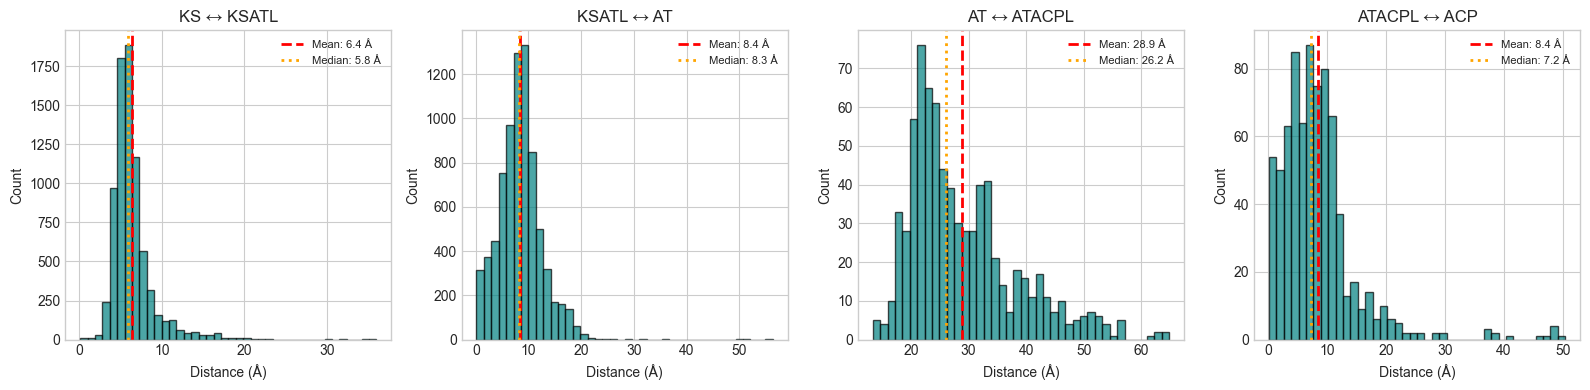

In [23]:
# Plot distance distributions for available key distances
if len(available_distances) >= 3:
    fig, axes = plt.subplots(1, min(4, len(available_distances)), figsize=(16, 4))
    if len(available_distances) < 4:
        axes = axes if hasattr(axes, '__iter__') else [axes]
    
    for i, dist_col in enumerate(available_distances[:4]):
        ax = axes[i]
        data = ido_df[dist_col].dropna()
        ax.hist(data, bins=40, edgecolor='black', alpha=0.7, color='teal')
        ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.1f} Å')
        ax.axvline(data.median(), color='orange', linestyle=':', linewidth=2, label=f'Median: {data.median():.1f} Å')
        ax.set_xlabel('Distance (Å)')
        ax.set_ylabel('Count')
        # Clean up column name for title
        title = dist_col.replace('dist.', '').replace('__', ' ↔ ')
        ax.set_title(title)
        ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()


In [ ]:
# ============================================================================
# COMPREHENSIVE INTER-DOMAIN DISTANCE ANALYSIS
# ============================================================================

# Get all distance columns between catalytic domains (not linkers)
catalytic_distance_cols = []
for col in distance_cols:
    domains = col.replace('dist.', '').split('__')
    if not any(is_linker_domain(d) for d in domains):
        catalytic_distance_cols.append(col)

print(f"Distance columns between catalytic domains: {len(catalytic_distance_cols)}")
print("\nExamples:")
for col in catalytic_distance_cols[:10]:
    print(f"  {col}")


In [ ]:
# Analyze key catalytic domain distances
# These are the most biologically relevant
key_catalytic_distances = [
    'dist.KS__AT', 'dist.KS__ACP', 'dist.AT__ACP', 'dist.KS__KR',
    'dist.KR__ACP', 'dist.DH__KR', 'dist.DH__ACP', 'dist.ER__KR',
    'dist.KS__DH', 'dist.AT__KR', 'dist.KS__TE', 'dist.ACP__TE'
]

available_key = [d for d in key_catalytic_distances if d in ido_df.columns]
print(f"Available key catalytic distances: {len(available_key)}")

# Calculate statistics for available distances
if available_key:
    distance_summary = ido_df[available_key].describe().round(2)
    print("\nDistance Statistics (Å):")
    display(distance_summary)


In [ ]:
# Comprehensive distance distribution plots
if len(available_key) >= 4:
    n_plots = min(12, len(available_key))
    n_cols = 4
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_plots == 1 else axes
    
    for i, dist_col in enumerate(available_key[:n_plots]):
        ax = axes[i]
        data = ido_df[dist_col].dropna()
        ax.hist(data, bins=40, edgecolor='black', alpha=0.7, color=plt.cm.plasma(i/n_plots))
        ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2)
        ax.axvline(data.median(), color='white', linestyle=':', linewidth=2)
        ax.set_xlabel('Distance (Å)')
        ax.set_ylabel('Count')
        title = dist_col.replace('dist.', '').replace('__', ' ↔ ')
        ax.set_title(f'{title}\nμ={data.mean():.1f}, σ={data.std():.1f} Å', fontsize=10)
    
    # Hide empty subplots
    for j in range(n_plots, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Inter-Domain Centroid Distances (Catalytic Domains)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


In [ ]:
# Distance correlation heatmap for key domains
if len(available_key) >= 4:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create correlation matrix
    dist_corr = ido_df[available_key].corr()
    
    # Clean up labels
    clean_labels = [c.replace('dist.', '').replace('__', '↔') for c in available_key]
    dist_corr.index = clean_labels
    dist_corr.columns = clean_labels
    
    sns.heatmap(dist_corr, annot=True, cmap='RdBu_r', center=0, ax=ax, fmt='.2f',
                annot_kws={'size': 8})
    ax.set_title('Correlation Between Inter-Domain Distances', fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
# ============================================================================
# ROTATION MATRIX INTERPRETATION
# ============================================================================
# The rotation matrices describe the orientation of structures
# We can extract Euler angles to understand orientational preferences

def rotation_matrix_to_euler(R_flat):
    """Convert flattened rotation matrix to Euler angles (degrees)"""
    try:
        R = np.array(R_flat).reshape(3, 3)
        r = Rotation.from_matrix(R)
        return r.as_euler('xyz', degrees=True)
    except:
        return [np.nan, np.nan, np.nan]

# Extract rotation matrix values
R_cols = ['R.00', 'R.01', 'R.02', 'R.10', 'R.11', 'R.12', 'R.20', 'R.21', 'R.22']

if all(c in ido_df.columns for c in R_cols):
    # Convert to Euler angles for a subset (full dataset takes time)
    sample_size = min(1000, len(ido_df))
    sample_df = ido_df.sample(sample_size, random_state=42)
    
    euler_angles = []
    for idx, row in sample_df.iterrows():
        R_flat = [row[c] for c in R_cols]
        angles = rotation_matrix_to_euler(R_flat)
        euler_angles.append(angles)
    
    euler_df = pd.DataFrame(euler_angles, columns=['Roll (X)', 'Pitch (Y)', 'Yaw (Z)'])
    
    print("Euler Angle Statistics (degrees):")
    print(euler_df.describe().round(2))


In [ ]:
# Visualize rotation angle distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, angle_name in enumerate(['Roll (X)', 'Pitch (Y)', 'Yaw (Z)']):
    ax = axes[i]
    data = euler_df[angle_name].dropna()
    ax.hist(data, bins=50, edgecolor='black', alpha=0.7, color=plt.cm.viridis(i/3))
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='0°')
    ax.set_xlabel(f'{angle_name} (degrees)')
    ax.set_ylabel('Count')
    ax.set_title(f'{angle_name} Distribution\nμ={data.mean():.1f}°, σ={data.std():.1f}°')
    ax.legend()

plt.suptitle('Global Orientation Angles (from Rotation Matrices)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Translation vector analysis
t_cols = ['t.0', 't.1', 't.2']
if all(c in ido_df.columns for c in t_cols):
    print("\nTranslation Vector Statistics:")
    print(ido_df[t_cols].describe().round(2))


In [ ]:
# ============================================================================
# DOMAIN CENTROID ANALYSIS
# ============================================================================

# Extract centroid columns for catalytic domains
catalytic_domains_list = ['KS', 'AT', 'ACP', 'KR', 'DH', 'ER', 'TE', 'cMT', 'oMT', 'R']
centroid_cols_by_domain = {}

for domain in catalytic_domains_list:
    x_col = f'centroid.{domain}.0'
    y_col = f'centroid.{domain}.1'
    z_col = f'centroid.{domain}.2'
    if all(c in ido_df.columns for c in [x_col, y_col, z_col]):
        centroid_cols_by_domain[domain] = [x_col, y_col, z_col]

print(f"Domains with centroid data: {list(centroid_cols_by_domain.keys())}")

# Calculate centroid spread (how distributed are domain positions)
centroid_stats = {}
for domain, cols in centroid_cols_by_domain.items():
    data = ido_df[cols].dropna()
    if len(data) > 0:
        centroid_stats[domain] = {
            'n_samples': len(data),
            'x_std': data[cols[0]].std(),
            'y_std': data[cols[1]].std(),
            'z_std': data[cols[2]].std(),
            'total_spread': np.sqrt(data[cols[0]].std()**2 + data[cols[1]].std()**2 + data[cols[2]].std()**2)
        }

centroid_df = pd.DataFrame(centroid_stats).T.round(2)
print("\nCentroid Position Variability by Domain:")
display(centroid_df.sort_values('total_spread', ascending=False))


---
## 5. Combined Data (MP_IA_IDO_combined.csv)

Master file combining macroproperties with inter-domain organization data (1,043 columns total).


In [24]:
# Load combined data (preview)
combined_df = pd.read_csv('MP_IA_IDO_combined.csv', nrows=100)

print(f"Shape (preview of 100 rows): {combined_df.shape}")
print(f"Total columns: {len(combined_df.columns)}")


Shape (preview of 100 rows): (100, 1043)
Total columns: 1043


In [25]:
# Check column overlap with source files
mp_cols = set(module_mp.columns)
ido_cols = set(ido_df.columns)
combined_cols = set(combined_df.columns)

print(f"Columns shared with MP_PKS: {len(mp_cols & combined_cols)}")
print(f"Columns shared with IDO_out: {len(ido_cols & combined_cols)}")
print(f"\nFirst 25 columns in combined file:")
for i, col in enumerate(combined_df.columns[:25]):
    print(f"  {i+1}. {col}")


Columns shared with MP_PKS: 12
Columns shared with IDO_out: 1029

First 25 columns in combined file:
  1. Unnamed: 0
  2. filename
  3. msms_density
  4. n_ca_atoms
  5. n_heavy_atoms
  6. probe_radius
  7. radius_of_gyration_ca
  8. sasa
  9. ses_area
  10. vdw_volume
  11. vox_size
  12. zernike
  13. zernike_order
  14. domains
  15. interfaces
  16. _error
  17. R.00
  18. R.01
  19. R.02
  20. R.10
  21. R.11
  22. R.12
  23. R.20
  24. R.21
  25. R.22


---
## PKS Domain Reference Guide

### Catalytic Domains

| Domain | Full Name | Function |
|--------|-----------|----------|
| **KS** | Ketosynthase | Catalyzes C-C bond formation (Claisen condensation) |
| **AT** | Acyltransferase | Loads extender units onto ACP |
| **ACP** | Acyl Carrier Protein | Shuttles growing polyketide chain between domains |
| **KR** | Ketoreductase | Reduces beta-keto to beta-hydroxy group |
| **DH** | Dehydratase | Removes water to form double bond |
| **ER** | Enoylreductase | Reduces double bond to single bond |
| **TE** | Thioesterase | Releases and often cyclizes final product |
| **cMT** | C-Methyltransferase | Adds methyl group to carbon |
| **oMT** | O-Methyltransferase | Adds methyl group to oxygen |
| **R** | Reductase | Terminal reduction |

### Linker Domains (connect catalytic domains)

| Linker | Connects |
|--------|----------|
| **KSATL** | KS to AT |
| **ATACPL** | AT to ACP |
| **ATDHL** | AT to DH |
| **DHKRL** | DH to KR |
| **KRACPL** | KR to ACP |
| **ERKRL** | ER to KR |
| **ACPRL** | ACP to R |
| **ACPTEL** | ACP to TE |


In [26]:
# Final summary table
summary_data = {
    'File': ['domain_macroproperties.csv', 'MP_PKS.csv', 'IA_out.csv', 'IDO_out.csv', 'MP_IA_IDO_combined.csv'],
    'Rows': [65012, 8004, 7734, 7734, 8006],
    'Columns': [13, 12, 3, 1029, 1043],
    'Primary Use': [
        'Individual domain structural properties',
        'Full module structural properties',
        'Domain-domain interface residue contacts',
        'Inter-domain spatial relationships',
        'Comprehensive analysis (all features combined)'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("=" * 80)
print("DATASET SUMMARY")
print("=" * 80)
display(summary_df)


DATASET SUMMARY


,File,Rows,Columns,Primary Use
0,domain_macroproperties.csv,65012,13,Individual domain structural properties
1,MP_PKS.csv,8004,12,Full module structural properties
2,IA_out.csv,7734,3,Domain-domain interface residue contacts
3,IDO_out.csv,7734,1029,Inter-domain spatial relationships
4,MP_IA_IDO_combined.csv,8006,1043,Comprehensive analysis (all features combined)


---
## Suggested Next Steps for EDA

### Analysis Ideas:

1. **Domain Size Analysis**
   - Compare structural properties (SASA, volume, Rg) across domain types
   - Identify outliers or unusual domains

2. **Module Architecture Patterns**
   - What domain combinations are most common?
   - How do module sizes vary?

3. **Inter-Domain Distance Analysis**
   - Which domains are typically closest/furthest?
   - Are there characteristic distance patterns for different module types?

4. **Interface Analysis**
   - Which interfaces have the most residue contacts?
   - Are there conserved interface patterns?

5. **Structural Variation**
   - How much do predictions vary between models (model_0 vs model_1, etc.)?
   - Which domains show most structural variability?

6. **BGC-Level Analysis**
   - Group by BGC to study clusters
   - Compare structural features across different natural product classes

7. **Correlation Analysis**
   - Relationships between domain size and surface area
   - Relationships between domain distances and module function


In [27]:
# Show example columns from each category
print("=== Example columns from each category ===")
for cat, cols in col_categories.items():
    print(f"\n{cat.upper()}:")
    for c in cols[:5]:
        print(f"  {c}")
    if len(cols) > 5:
        print(f"  ... ({len(cols) - 5} more)")


=== Example columns from each category ===

ROTATION:
  R.00
  R.01
  R.02
  R.10
  R.11
  ... (4 more)

TRANSLATION:
  t.0
  t.1
  t.2

CENTROIDS:
  centroid.ACP.0
  centroid.ACP.1
  centroid.ACP.2
  centroid.ACPRL.0
  centroid.ACPRL.1
  ... (88 more)

DISTANCES:
  dist.ACPRL__ACP
  dist.ACPRL__ACPRL
  dist.ACPRL__AT
  dist.ACPRL__ATACPL
  dist.ACPRL__ATDHL
  ... (488 more)

DOMAIN_BOUNDARIES:
  domain.ACP.end
  domain.ACP.start
  domain.ACPRL.end
  domain.ACPRL.start
  domain.ACPTEL.end
  ... (57 more)

PARTNER_DATA:
  partner.ACP.R.00
  partner.ACP.R.01
  partner.ACP.R.02
  partner.ACP.R.10
  partner.ACP.R.11
  ... (355 more)

REFERENCE:
  ref_key
  ref_key_0
  ref_key_1
  ref_key_2
  ref_key_3
